In [1]:
import pandas as pd
import numpy as np
import librosa
import IPython.display as ipd
from librosa.display import specshow
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/data HS.csv")
data = data.apply(pd.to_numeric)
data.index = range(len(data.index))
data = data.sort_values(by=['Temps (min)'])
data.loc[:,'2905.mzML':] = data.loc[:,'2905.mzML':].applymap(np.log)

In [3]:
pd.set_option('display.max_columns', 15)
data.describe()

,Masse (mz),Temps (min),2905.mzML,2915.mzML,2910.mzML,2908.mzML,2907.mzML,...,3069.mzML,3070.mzML,3064.mzML,3071.mzML,3072.mzML,3073.mzML,Unnamed: 171
count,953.000000,953.000000,257.000000,597.000000,938.000000,942.000000,941.000000,...,789.000000,754.000000,821.000000,801.000000,813.000000,937.000000,0.0
mean,401.237266,12.775593,11.926353,12.317468,13.998088,13.967346,13.958635,...,12.620999,12.968401,13.423927,13.207887,13.055290,13.844849,NaN
std,182.765170,9.082042,3.511650,2.762897,1.831448,1.897797,1.894486,...,2.570495,2.681348,2.513927,2.661562,2.722833,1.840990,NaN
min,100.076200,0.070000,7.050952,7.369868,7.554560,7.029021,7.407205,...,6.657372,6.438135,6.437472,6.816665,6.403856,6.521257,NaN
25%,251.090900,3.450000,8.777498,10.030649,12.992711,12.971277,12.951902,...,10.856337,11.160825,11.966013,11.401371,11.329269,12.812267,NaN
50%,385.221100,12.790000,11.137672,12.355275,14.028820,14.017943,14.004657,...,12.772904,13.489097,13.837531,13.518024,13.470308,13.887349,NaN
75%,529.268100,17.630000,14.951587,14.374544,15.034141,15.048209,15.018363,...,14.526844,14.888700,15.196967,15.128743,15.071262,14.949742,NaN
max,799.563300,33.730000,21.043190,21.701000,20.658458,21.502158,20.729492,...,21.043648,20.481150,21.070608,21.109835,20.430192,20.961053,NaN


In [4]:
# Structure d'entrée attendue : vecteur taille m et matrice taille n*m avec : 
# n = durée_expérience / résolution_temporelle = nombre de relevés pendant l'expérience
# m = nombre de molécules distinctes ("Masse (mz)" distincte)

def son(mass_vector, abundance_matrix, sr=22050, duration=35):
    try:
        assert(len(mass_vector) == len(abundance_matrix[0]))
    except:
        raise(Exception("Pas la bonne taille de données"))
    
    n = len(abundance_matrix)
    m = len(mass_vector)
    durationOfOneSample = duration*sr/n
    
    amplitude_matrix = abundance_matrix / np.max(abundance_matrix) # On ramène l'amplitude dans ]0,1]
    
    sounds = np.zeros((duration*sr,m)) # Chaque colonne est une molécule différente, chaque ligne est une unité temporelle
    
    for i in tqdm.tqdm(range(duration*sr)): # Parcours par temps croissant (on suppose la matrice d'abondance triée)
        ### Update par rapport à son_v2.ipynb : Interpolation ###
        sampleNumber = int(i/durationOfOneSample)
        if sampleNumber < len(abundance_matrix) - 1:
            sampleProgress = i%durationOfOneSample
            sampleCurrent = abundance_matrix[sampleNumber]
            sampleNext = abundance_matrix[sampleNumber+1]
            sampleInterpolation = (sampleNext-sampleCurrent)/durationOfOneSample * sampleProgress + sampleCurrent
        else:
            sampleInterpolation = sampleCurrent
        ### Fin de l'update ###
        t = i/sr # temps
        
        for j in range(m): # Parcours de toutes les molécules pour un instant donné
            freq = mass_vector[j] # fréquence
            amp = sampleInterpolation[j] # amplitude
            sounds[i][j] = amp * np.sin(np.pi*freq*t)
    
    return np.mean(sounds,axis=1) # Fusion des channels de toutes les molécules

In [5]:
def instrument_violon(matrix_freq_time):
    amplitudes = np.array([0.41,0.99,0.16,0.1,0.49,0.17,0.1,0.03,0.04,0.03])
    partials = np.arange(1,11,1)
    violon = np.tile(matrix_freq_time,(10,1,1))
    violon = (violon.T * partials).T
    violon = np.sin(np.pi * violon)
    violon = (violon.T * amplitudes).T
    return np.mean(violon, axis=0)

In [6]:
def son_optimise(mass_vector, abundance_matrix, sr=22050, duration=35, instrument="sinus"):
    try:
        assert(len(mass_vector) == len(abundance_matrix[0]))
    except:
        raise(Exception("Pas la bonne taille de données"))
    
    durationOfOneSample = duration*sr/len(abundance_matrix)
    
    time_vector = np.arange(0,duration*sr,1) / sr
    
    time_vector = time_vector.reshape((len(time_vector),1))
    mass_vector = np.transpose(mass_vector.reshape((len(mass_vector),1)))
    
    ### Update par rapport à son_v2.ipynb : Interpolation + Instruments ###
    amplitude_matrix = np.array(
        [(abundance_matrix[int(i/durationOfOneSample)+1] - abundance_matrix[int(i/durationOfOneSample)]) / durationOfOneSample * (i%durationOfOneSample) + abundance_matrix[int(i/durationOfOneSample)]  
         if int(i/durationOfOneSample) < len(abundance_matrix) - 1 
         else abundance_matrix[int(i/durationOfOneSample)]
         for i in range(duration*sr)]
    )
    
    if instrument == "sinus":
        sounds = np.multiply(amplitude_matrix, np.sin(np.pi * np.matmul(time_vector, mass_vector)))
    elif instrument == "violon":
        sounds = np.multiply(amplitude_matrix, instrument_violon(np.matmul(time_vector, mass_vector)))
    else:
        raise Exception("Invalid Instrument")
    ### Fin de l'update ###
    
    audio = np.mean(sounds,axis=1)
    
    return audio / np.max(audio)

In [7]:
def generate_test_abundance_matrix(df, column, nb_pics=None):
    ### Update par rapport à son_v2.ipynb ###
    # nb_pics = nombre de pics à garder (en partant du plus haut)
    spike_height = df[column].loc[df[column] > 0].to_numpy() # amplitude des pics
    spike_time = df["Temps (min)"].loc[df[column] > 0].to_numpy() # position temporelle des pics
    
    if nb_pics is None or nb_pics <= 0: 
        nb_pics = len(spike_height)
    
    sorted_spike_height = np.sort(spike_height)
    nth_max_spike_height = sorted_spike_height[len(spike_height) - nb_pics]
    
    spike_height[spike_height < nth_max_spike_height] = 0
    ### Fin de l'update ###
    
    sigma = 1/np.sqrt(2*np.pi) # variance de la gaussienne, ici choisi pour que le max de la gaussienne soit 1
    amp = 1/np.sqrt(2*np.pi*sigma**2) # terme multiplicatif de la gaussienne
    
    n = int(35/0.07)   # nombre de relevés pendant l'expérience
    m = len(spike_height) # nombre de molécules PRESENTES DANS L'ECHANTILLON différentes
    abundance_matrix = np.zeros((n,m))
    
    for i in range(n):
        t = i*0.07
        for j in range(m):
            if not np.isnan(spike_height[j]):
                abundance_matrix[i][j] = amp * spike_height[j] * np.exp(-(t-spike_time[j])**2 / (2*sigma**2))
    return abundance_matrix

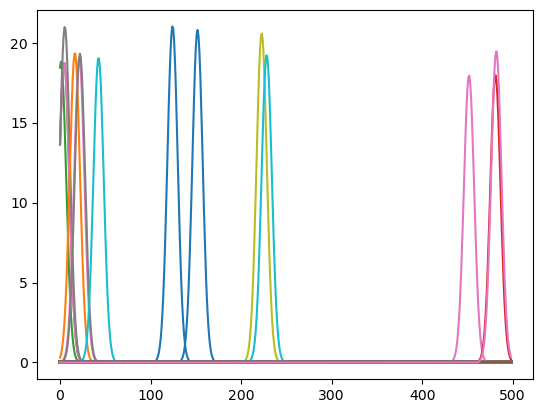

In [16]:
am = generate_test_abundance_matrix(data,"2905.mzML",15)
plt.plot(am);

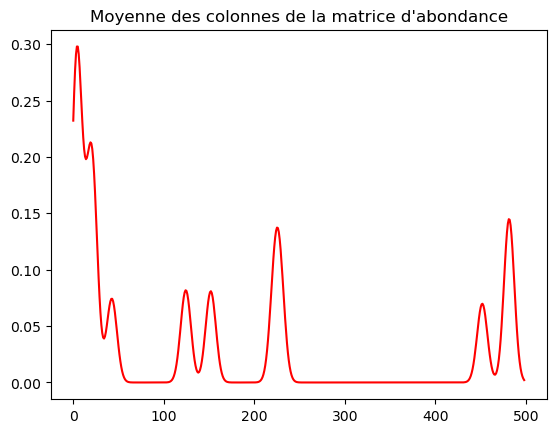

In [17]:
plt.plot(np.mean(am,axis=1),color='red');
plt.title("Moyenne des colonnes de la matrice d'abondance");

In [18]:
# Paramètres

sr = 11000 # sampling rate (fréquence d'échantillonage)
duration = 5
mass_vector = data["Masse (mz)"].loc[data["2905.mzML"] > 0].to_numpy()
mass_vector = 1000 - mass_vector # On "inverse" les masses : les molécules plus légères (masse plus faible) seront plus aigües (fréquence plus forte)
abundance_matrix =am

In [19]:
%%time
audio = son_optimise(mass_vector, abundance_matrix, sr, duration)
display(ipd.Audio(audio, rate=sr))

CPU times: user 4.01 s, sys: 807 ms, total: 4.81 s
Wall time: 4.99 s


In [12]:
%%time
audio = son_optimise(mass_vector, abundance_matrix, sr, duration, "violon")
display(ipd.Audio(audio, rate=sr))

CPU times: user 17.8 s, sys: 18 s, total: 35.9 s
Wall time: 45.8 s


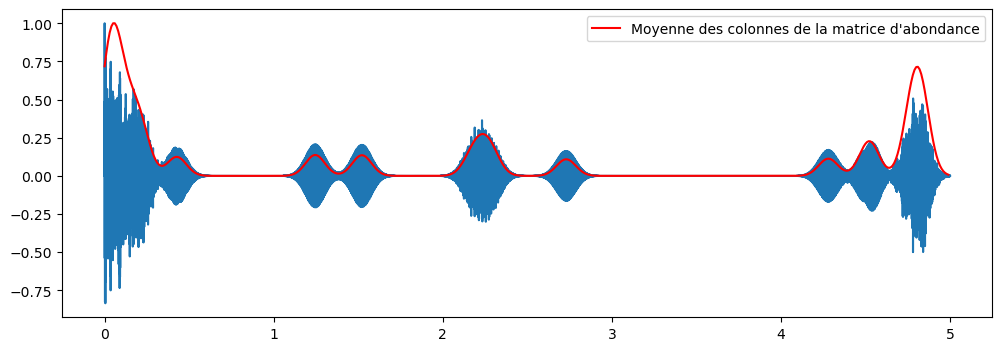

In [13]:
plt.figure(figsize=(12,4))
plt.plot(np.arange(0,duration,1/sr),audio);
plt.plot(np.arange(0,duration,duration/len(am)),np.mean(am,axis=1)/np.max(np.mean(am,axis=1)),color='red',label="Moyenne des colonnes de la matrice d'abondance")
plt.legend();

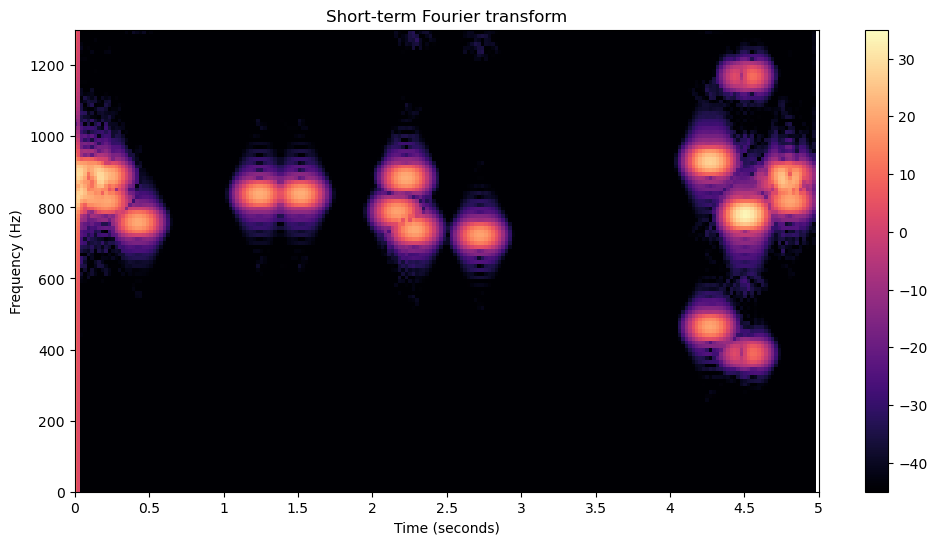

In [14]:
# Affichage du spectrogramme

plt.figure(figsize=(12, 6))

y_stft = librosa.stft(np.array(audio), win_length=1024)
y_spectrogram = librosa.amplitude_to_db(np.abs(y_stft))
specshow(y_spectrogram, cmap="magma", x_axis="time", y_axis="hz")
plt.title("Short-term Fourier transform")
plt.colorbar()
plt.xlabel("Time (seconds)")
plt.xlim(0, duration)
plt.ylabel("Frequency (Hz)")
plt.ylim(0, 1300);

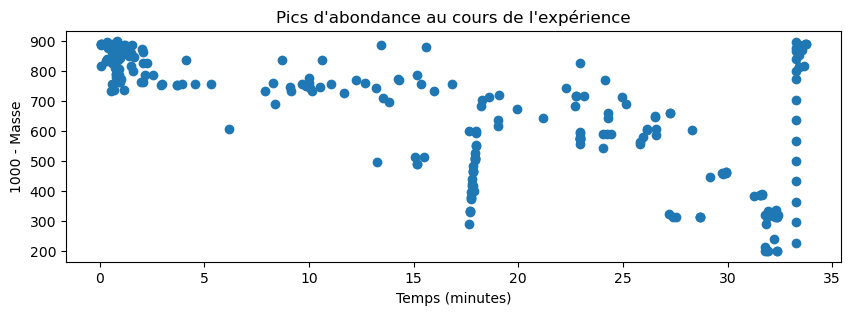

In [15]:
plt.figure(figsize=(10,3))
plt.scatter(data["Temps (min)"].loc[data["2905.mzML"] > 0],1000 - data["Masse (mz)"].loc[data["2905.mzML"] > 0])
plt.xlabel("Temps (minutes)")
plt.ylabel("1000 - Masse")
plt.title("Pics d'abondance au cours de l'expérience");